<a href="https://colab.research.google.com/github/OoJackoO/MMAI894_Deep-Learning-Course-Project/blob/dev/Tony/Tony%E2%80%98s_data_input.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/NewDrive/')

Drive already mounted at /content/NewDrive/; to attempt to forcibly remount, call drive.mount("/content/NewDrive/", force_remount=True).


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/NewDrive/MyDrive/MMAI894TeamProject"

In [ ]:
%cd /content/NewDrive/MyDrive/MMAI894TeamProject

/content/NewDrive/MyDrive/MMAI894TeamProject


In [ ]:
#!kaggle datasets download -d cookiefinder/tomato-disease-multiple-sources

In [ ]:
%ls

 kaggle.json                          'Tony‘s data input.ipynb'   valid/
 tomato-disease-multiple-sources.zip   train/


In [ ]:
#!unzip tomato-disease-multiple-sources.zip


In [ ]:
# import os

# path = "/content/NewDrive/MyDrive/MMAI894TeamProject/train" # replace with the path to your unzipped folder
# file_count = 0

# for root, dirs, files in os.walk(path):
#     file_count += len(files)

# print("Number of files in the unzipped folder and its subdirectories:", file_count)

In [ ]:
# data manipulation
import numpy as np
import pandas as pd

# image processing
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set_style('darkgrid')

# data preprocessing and modeling
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras import layers

# sklearn utility functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# others
import os, gc, time
import tqdm, re, json
import glob 
from skimage import io 

# set up random seed
import random
seed = 24

# customize printing
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
pd.set_option('max_colwidth', 200)
     

# mount Google Drive to Google Colab notebook
from google.colab import drive
drive.mount('/content/NewDrive')
     


# environmental variables
TRAIN_DATA_PATH = '/content/NewDrive/MyDrive/MMAI894TeamProject/train'
VALID_DATA_PATH = '/content/NewDrive/MyDrive/MMAI894TeamProject/valid'
     

Drive already mounted at /content/NewDrive; to attempt to forcibly remount, call drive.mount("/content/NewDrive", force_remount=True).


In [ ]:
def create_path_df(dir, quality_check=False):
  """
  This function creates dataframe with class labels and image paths.
    inputs: 
      - dir: image folders
      - quality_check: whether to check image quality. Increase processing time if sets to 'True'
    outputs:
      - df: dataframe
  """
  filepaths = []
  labels = []
  bad_images = []

  # validate directory
  assert os.path.exists(dir), "Error: directory does not exist"

  # get image paths
  classes = sorted([c for c in os.listdir(dir) if os.path.isdir(os.path.join(dir, c))])

  for f_class in classes:
    class_path = os.path.join(dir, f_class)
    file_list = os.listdir(class_path)
    desc = f'{f_class:23s}'
    for file in tqdm.tqdm(file_list, ncols=110, desc=desc, unit='file', colour='blue'):
      fpath = os.path.join(class_path, file)

      # if I want to check image quality - first time running
      if quality_check:
        index = file.rfind('.')
        if file[index:] in ['.jpg', '.png', '.jpeg', '.PNG', '.JPG', '.JPEG']:
          try:
            img = cv2.imread(fpath)
            filepaths.append(fpath)
            labels.append(f_class)
          except:
            bad_images.append(fpath)
            print('defective image file: ', fpath)
        else:
            bad_images.append(fpath)

      # skip image quality check
      filepaths.append(fpath)
      labels.append(f_class)

    # create dataframe with file paths
  Fseries = pd.Series(filepaths, name= 'filepaths')
  Lseries = pd.Series(labels, name='labels') 
  df = pd.concat([Fseries, Lseries], axis= 1)

  # summary outputs
  print('\n{} classes of images are imported. \n{} bad images'.format(df.shape[1], len(bad_images)))
  return df

In [ ]:
def df_split(dir_train, dir_valid, qa_train=False, qa_valid=False, seed=seed, split_ratio = 0.5):
  """
  This function creates dataframes with class labels and image paths and completes train/val/test split.
  """
  # train dataframe
  train_df = create_path_df(dir_train, qa_train)
  
  # valid and test dataframe
  val_test_df = create_path_df(dir_valid, qa_valid)
  strat = val_test_df['labels']
  valid_df, test_df = train_test_split(val_test_df,  train_size=split_ratio, stratify= strat, shuffle= True, random_state= seed)

  return train_df, valid_df, test_df

In [ ]:
train_df, valid_df, test_df = df_split(dir_train=TRAIN_DATA_PATH, dir_valid = VALID_DATA_PATH)

powdery_mildew         : 100%|██████████████████████████████████████| 1004/1004 [00:00<00:00, 353515.88file/s]



2 classes of images are imported. 
0 bad images


powdery_mildew         : 100%|████████████████████████████████████████| 252/252 [00:00<00:00, 322048.94file/s]



2 classes of images are imported. 
0 bad images


In [ ]:
'''
# check image size
sample_df = train_df.sample(n=300, replace=False)
image_size_dict = dict()
for i in range(len(sample_df)):
    fpath = sample_df['filepaths'].iloc[i]
    try:
      img = cv2.imread(fpath)
      h_w = (img.shape[0], img.shape[1])
      image_size_dict[h_w] = image_size_dict.get(h_w, 0) + 1
    except:
        pass

{ k: v for k,v in image_size_dict.items() if v > 10}
'''

"\n# check image size\nsample_df = train_df.sample(n=300, replace=False)\nimage_size_dict = dict()\nfor i in range(len(sample_df)):\n    fpath = sample_df['filepaths'].iloc[i]\n    try:\n      img = cv2.imread(fpath)\n      h_w = (img.shape[0], img.shape[1])\n      image_size_dict[h_w] = image_size_dict.get(h_w, 0) + 1\n    except:\n        pass\n\n{ k: v for k,v in image_size_dict.items() if v > 10}\n"

In [ ]:
IMAGE_SIZE = 224 
BATCH_SIZE = 32
LABEL_MODE = 'categorical'

train_ds = tf.keras.utils.image_dataset_from_directory(TRAIN_DATA_PATH,
    labels='inferred',
    label_mode='int',
    class_names=os.listdir(TRAIN_DATA_PATH),
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=24,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,)
val_test_ds = tf.keras.utils.image_dataset_from_directory(VALID_DATA_PATH,    
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=24,
    validation_split=0.5,
    subset='both',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,)

valid_ds = val_test_ds[0]
test_ds = val_test_ds[1]

Found 25851 files belonging to 11 classes.
Found 6684 files belonging to 11 classes.
Using 3342 files for training.
Using 3342 files for validation.


In [ ]:
def show_images(ds, no_batch=6):
  class_names = ds.class_names 
  plt.figure(figsize= (16, 32))
  for images, labels in ds.take(no_batch):
    for i in range(len(images)):
      ax = plt.subplot(len(images)//4 + 1, 4, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      index = np.argmax(labels[i])
      plt.title(class_names[index], fontsize=12)
      plt.axis("off")
  plt.show()

In [ ]:
#show_images(train_ds)

In [ ]:
import glob 

In [ ]:
test_path = os.path.join(TRAIN_DATA_PATH, 'Leaf_Mold', '*')
test_path = glob.glob(test_path)

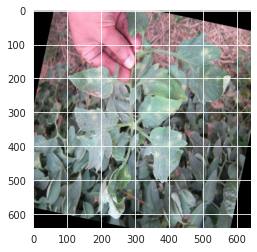

In [ ]:
image = io.imread(test_path[6])  

# plotting the original image
i, (im1) = plt.subplots(1)
i.set_figwidth(15)
im1.imshow(image)

Text(0.5, 0.98, 'Original & RGB image channels')

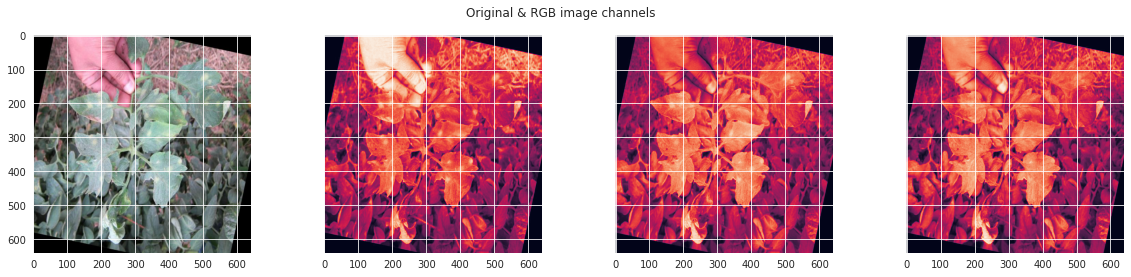

In [ ]:
# plotting the original image and the RGB channels  

i, (im1, im2, im3, im4) = plt.subplots(1, 4, sharey=True)
i.set_figwidth(20) 

im1.imshow(image)  #Original image
im2.imshow(image[:, : , 0]) #Red
im3.imshow(image[:, : , 1]) #Green
im4.imshow(image[:, : , 2]) #Blue
i.suptitle('Original & RGB image channels')

In [ ]:
import skimage

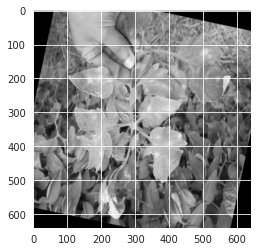

In [ ]:
gray_image = skimage.color.rgb2gray(image)
plt.imshow(gray_image, cmap = 'gray')

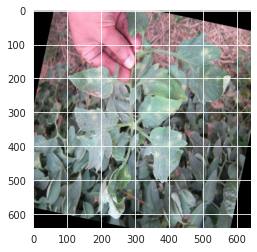

In [ ]:
norm_image = (image - np.min(image)) / (np.max(image) - np.min(image))
plt.imshow(norm_image)

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(32, 224, 224, 3)
(32,)


In [ ]:
'''
# import libraries

from numpy import expand_dims
from tensorflow.keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator,array_to_img

# create image data augmentation generator
#datagen = ImageDataGenerator(rotation_range=20,width_shift_range=0.1,height_shift_range=0.1,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,fill_mode='nearest')
datagen = ImageDataGenerator(rotation_range=20)
input_shape = (224, 224)

augmented_data = datagen.flow_from_directory('/content/NewDrive/MyDrive/MMAI894TeamProject/train/Bacterial_spot',target_size=input_shape,batch_size=BATCH_SIZE,class_mode=LABEL_MODE,save_prefix='trans_')\

'''

"\n# import libraries\n\nfrom numpy import expand_dims\nfrom tensorflow.keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator,array_to_img\n\n# create image data augmentation generator\n#datagen = ImageDataGenerator(rotation_range=20,width_shift_range=0.1,height_shift_range=0.1,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,fill_mode='nearest')\ndatagen = ImageDataGenerator(rotation_range=20)\ninput_shape = (224, 224)\n\naugmented_data = datagen.flow_from_directory('/content/NewDrive/MyDrive/MMAI894TeamProject/train/Bacterial_spot',target_size=input_shape,batch_size=BATCH_SIZE,class_mode=LABEL_MODE,save_prefix='trans_')\n"

# **Vision Transformer build up**

In [ ]:
# Define data generators with augmentation
train_datagen = ImageDataGenerator(rescale=1./255)

valid_datagen = ImageDataGenerator(rescale=1./255)



In [ ]:
# Create data loaders from generators
train_loader = train_datagen.flow_from_dataframe(
    train_df,
    x_col="filepaths",
    y_col="labels",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode=LABEL_MODE
)

valid_loader = valid_datagen.flow_from_dataframe(
    valid_df,
    x_col="filepaths",
    y_col="labels",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode=LABEL_MODE
)

Found 25851 validated image filenames belonging to 11 classes.
Found 3342 validated image filenames belonging to 11 classes.


In [ ]:
# # Define the baseline Vision Transformer model
# input_shape = (224, 224, 3)
# num_classes = 11

# model = Sequential([
#     layers.Conv2D(32, 3, activation="relu", input_shape=input_shape),
#     layers.MaxPooling2D(pool_size=(2, 2)),
#     layers.Conv2D(64, 3, activation="relu"),
#     layers.MaxPooling2D(pool_size=(2, 2)),
#     layers.Flatten(),
#     layers.Dense(128, activation="relu"),
#     layers.Dropout(0.5),
#     layers.Dense(num_classes, activation="softmax")
# ])



In [ ]:
# # Compile the model
# model.compile(
#     optimizer='adam',
#     loss="categorical_crossentropy",
#     metrics=["accuracy"]
# )

# # Fit the model
# history = model.fit(
#     train_loader,
#     epochs=50,
#     validation_data=valid_loader
# )

# **Use MobileNet as pre-trained model**

In [ ]:
from tensorflow.keras.applications import MobileNet

input_shape = (224, 224, 3)

base_model = MobileNet(
    input_shape=input_shape,
    include_top=False,
    weights="imagenet"
)

for layer in base_model.layers:
    layer.trainable = False

17225924/17225924 [==============================] - 0s 0us/step


In [ ]:
# Add a few layers on top of the base model for fine-tuning
num_classes = 11
model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax")
])

In [ ]:
# Compile the model
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
# Fit the model to the data using a GPU
history = model.fit(
    train_loader,
    epochs=10,
    validation_data=valid_loader,
    steps_per_epoch=len(train_loader),
    validation_steps=len(valid_loader),
    use_multiprocessing=True,
    workers=8
)

Epoch 1/10
808/808 [==============================] - 1210s 1s/step - loss: 1.2403 - accuracy: 0.5679 - val_loss: 0.6777 - val_accuracy: 0.7711
Epoch 2/10
808/808 [==============================] - 1158s 1s/step - loss: 0.8611 - accuracy: 0.6968 - val_loss: 0.5648 - val_accuracy: 0.8109
Epoch 3/10
808/808 [==============================] - 1185s 1s/step - loss: 0.7857 - accuracy: 0.7271 - val_loss: 0.4883 - val_accuracy: 0.8312
Epoch 4/10
808/808 [==============================] - 1160s 1s/step - loss: 0.7284 - accuracy: 0.7422 - val_loss: 0.4799 - val_accuracy: 0.8375
Epoch 5/10
808/808 [==============================] - 1190s 1s/step - loss: 0.7036 - accuracy: 0.7533 - val_loss: 0.4367 - val_accuracy: 0.8507
Epoch 6/10
808/808 [==============================] - 1154s 1s/step - loss: 0.6765 - accuracy: 0.7610 - val_loss: 0.4269 - val_accuracy: 0.8540
Epoch 7/10
808/808 [==============================] - 1183s 1s/step - loss: 0.6542 - accuracy: 0.7676 - val_loss: 0.3998 - val_accuracy:

In [ ]:
 # Fit the model to the data using a GPU
history = model.fit(
    train_loader,
    epochs=10,
    validation_data=valid_loader,
    use_multiprocessing=True,
    workers=8
)

Epoch 1/10
808/808 [==============================] - 626s 745ms/step - loss: 1.0611 - accuracy: 0.6363 - val_loss: 0.5183 - val_accuracy: 0.8220
Epoch 2/10
808/808 [==============================] - 207s 254ms/step - loss: 0.6546 - accuracy: 0.7723 - val_loss: 0.4159 - val_accuracy: 0.8698
Epoch 3/10
808/808 [==============================] - 197s 241ms/step - loss: 0.5424 - accuracy: 0.8117 - val_loss: 0.3831 - val_accuracy: 0.8630
Epoch 4/10
808/808 [==============================] - 206s 251ms/step - loss: 0.4886 - accuracy: 0.8281 - val_loss: 0.3319 - val_accuracy: 0.8866
Epoch 5/10
808/808 [==============================] - 202s 247ms/step - loss: 0.4399 - accuracy: 0.8441 - val_loss: 0.2976 - val_accuracy: 0.9016
Epoch 6/10
808/808 [==============================] - 194s 238ms/step - loss: 0.3999 - accuracy: 0.8607 - val_loss: 0.2819 - val_accuracy: 0.9051
Epoch 7/10
808/808 [==============================] - 195s 236ms/step - loss: 0.3778 - accuracy: 0.8655 - val_loss: 0.2689 -

# **Use VGG as pre-trained model**

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

VGG = VGG16(weights='imagenet', include_top=False,input_shape=(IMAGE_SIZE,IMAGE_SIZE,3))

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
num_classes = 11
model_VGG = Sequential([
    VGG,
    layers.GlobalAveragePooling2D(),
    layers.Dense(32,activation="relu"),
    layers.Dense(64,activation="relu"),
    layers.Flatten(),
    layers.Dense(128,activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation="softmax")
])


In [ ]:
for layer in model_VGG.layers:
    layer.trainable = False


In [ ]:
# Compile the model
model_VGG.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
history = model_VGG.fit(
    train_loader,
    epochs=10,
    validation_data=valid_loader,
    use_multiprocessing=True,
    workers=8
)

Epoch 1/10
 25/808 [..............................] - ETA: 31:13 - loss: 2.4258 - accuracy: 0.1163

# **CNN base model built up**

In [ ]:
model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(11, activation="softmax"),
])
     

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])
     

In [ ]:

model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=10
)
     

Epoch 1/10
 29/808 [>.............................] - ETA: 2:10:09 - loss: 2.5457 - accuracy: 0.1196

KeyboardInterrupt: ignored